<a href="https://colab.research.google.com/github/sujatasahoo/Natural_Language_Processing_NLP/blob/main/sujata_NLP_412_Vector_Representations_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Vector Representations
## *Data Science Unit 4 Sprint 1 Assignment 2*

## 0.1 Get `spacy`

In [ ]:
# Locally (or on colab) let's use en_core_web_lg 
!python -m spacy download en_core_web_md # Can do lg, takes awhile

     |████████████████████████████████| 96.4 MB 1.5 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=67a543b9a3345a8485a3d960554547e548f71849a203e5e4fb0afe437ccc954d
  Stored in directory: /tmp/pip-ephem-wheel-cache-obssnvbt/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


##0.2 Restart Runtime

In [ ]:
import spacy
nlp = spacy.load("en_core_web_md")

## 0.3 Imports

In [ ]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

%matplotlib inline



##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [ ]:
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git


Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1689, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 1689 (delta 90), reused 83 (delta 35), pack-reused 1531
Receiving objects: 100% (1689/1689), 59.25 MiB | 22.36 MiB/s, done.
Resolving deltas: 100% (259/259), done.


## 1) Clean the Job Listings from indeed.com that contain the title "Data Scientist" 

The file `job_listings.csv` is in the `data` folder for this module. <br>
Navigate to the `data` folder in the `DS-Unit-4-Sprint-1-NLP` folder icon in the left sidebar. 
Find the path to `job_listings.csv` (all the way at the bottom of the list of files in `data`), by clicking on the "three dots" symbol to the right of its file icon.

In [ ]:
data_path ="/content/DS-Unit-4-Sprint-1-NLP/module2-vector-representations/data/job_listings.csv"    
df = pd.read_csv(data_path)

In [ ]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


### Remove `HTML tags`

The text data in the description column is messy - it's full of html tags! <br>
Use the [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column by removing html tags. <br>
* You will need to read through the `BeautifulSoup` documentation to accomplish this task. <br>
* As with any library, there is lots of documentation, but read only what you need! 
* Don't spend more time than it takes to figure out how to remove html tags! 


In [ ]:
def remove_html(text):
    """
    Extract text from html boiler plate code. 
    Converts bytes dtype into str dtype
    
    Note
    ----
    Use the regex editor to help you create regular expressions https://regex101.com/
    
    Parameters
    ----------
    text: string or object 
        contains text data that we want to clean
    
    Returns 
    -------
    text: str 
        cleaned text data ready for vectorization
    """
    
    # create soup object 
    soup = BeautifulSoup(text, 'html.parser')
    
    # extract text from page using beautiful soup
    # eval will strip off whatever datatype or expression that's inside of a string 
    # see https://docs.python.org/3/library/functions.html#eval for eval docs
    text =  eval(soup.get_text())
    
    # if text is a byte data type, then convert to string 
    if isinstance(text, bytes):
        
        # convert byte data type into str
        text =  text.decode("utf-8")
        
    
    # use regex to clean your text data
    ###BEGIN SOLUTION
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text)
    ###END SOLUTION
    
    # case normalize and strip extra white spaces on the far left and right hand side
    text = text.lower().lstrip().rstrip()


    return text

In [ ]:
df["clean_text"] = df.description.apply(lambda text: remove_html(text))

#would this work?df["clean_text"] = df.description.apply(remove_html)

In [ ]:
df.clean_text

0      job requirements conceptual understanding in m...
1      job description as a data scientist you will h...
2      as a data scientist you will be working on con...
3      a monthcontractunder the general supervision o...
4      location usa multiple locations years of analy...
                             ...                        
421    about us want to be part of a fantastic and fu...
422    internshipat uber we ignite opportunity by set...
423    a yeara million people a year die in car colli...
424    senior data scientist job description about us...
425    cerner intelligence is a new innovative organi...
Name: clean_text, Length: 426, dtype: object

## 2) Use Spacy to tokenize the listings 
Remove stop words, punctuation and spaces, and whatever else you want to remove

In [ ]:
## YOUR CODE HERE
def tokenizer(text):
    """
    Uses spaCy language model to tokenize text. 
    Token filters are used to exclude low quality tokens.
    
    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token
    
    Input
    ----------
    text: string
        raw text document that needs to be tokenized
        
    Returns
    -------
    tokens: list of strings
    """
    # pass the raw text through the spacy language model
    doc = nlp(text)
    # create a list to store the tokens
    tokens = []
    # Begin Solution
    for token in doc:
      if (not token.is_punct) and (not token.is_stop) and (not token.is_space):
        tokens.append(token.lemma_.lower())
    return tokens

### Apply our tokenizer function via `pandas.apply()`

In [ ]:
df["lemmas"] = df.clean_text.apply(tokenizer)

In [ ]:
df["lemmas"]

0      [job, requirement, conceptual, understanding, ...
1      [job, description, data, scientist, help, buil...
2      [data, scientist, work, consult, business, res...
3      [monthcontractunder, general, supervision, pro...
4      [location, usa, multiple, location, year, anal...
                             ...                        
421    [want, fantastic, fun, startup, s, revolutioni...
422    [internshipat, uber, ignite, opportunity, set,...
423    [yeara, million, people, year, die, car, colli...
424    [senior, data, scientist, job, description, am...
425    [cerner, intelligence, new, innovative, organi...
Name: lemmas, Length: 426, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

- Instantiate a `CountVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `CountVectorizer`
- Use `CountVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `CountVectorizer` object
- Consider using `CountVectorizer` parameters like `stop_words` and `max_df`, `min_df` to trim your results
    
Once you've created your `dtm` dataframe, you might notice that some (or many) of your features result from data that still needs more cleaning. Use this as an opportunity to iteratively improve your `tokenizer` function. 

In [ ]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
vect = CountVectorizer(tokenizer=tokenizer, stop_words ="english")
dtm_tf = vect.fit_transform(df.clean_text)# Here, tf stands for "term frequency, i.e. counts for each term"
dtm_tf = pd.DataFrame(data=dtm_tf.toarray(), columns=vect.get_feature_names_out())
###END SOLUTION

In [ ]:
dtm_tf

,-pron-,aa,aap,ab,abernathy,abilitie,ability,able,abound,abroad,...,zero,zeus,zf,zheng,zillow,zogsports,zone,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts in a barplot

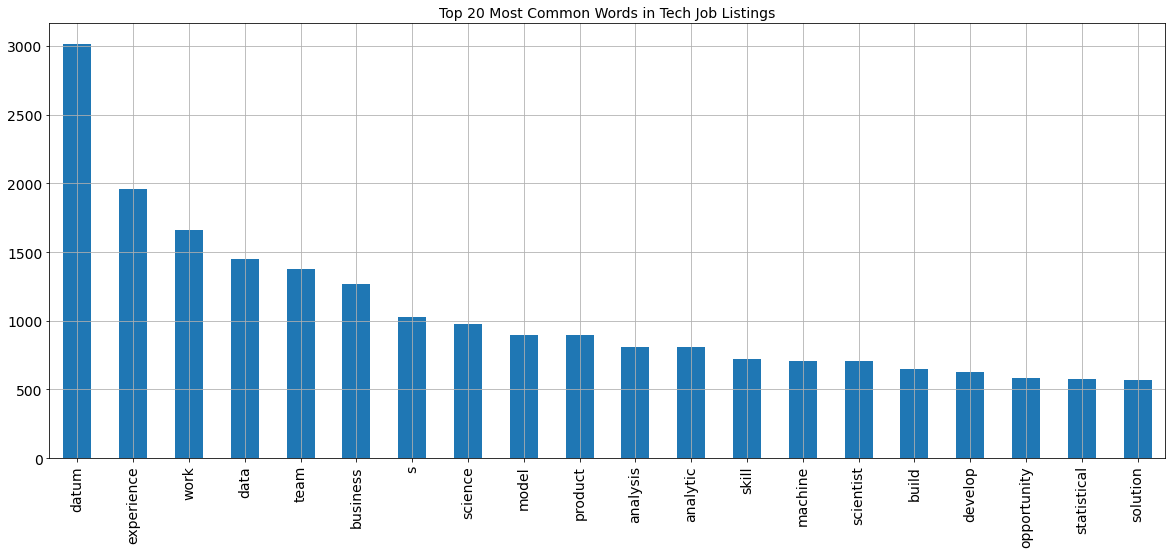

In [ ]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = dtm_tf.sum().sort_values(ascending=False)
#sorted_terms[:top_n].plot(kind='bar', figsize=(20,8), grid=True, fontsize=14);
plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
sorted_terms[:top_n].plot(kind='bar', figsize=(20, 8), grid=True, fontsize=14);
###END SOLUTION

## 5) Use Scikit-Learn's `TfidfVectorizer` to get a TF-IDF feature matrix

- Instantiate a `TfidfVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `TfidfVectorizer`
- Use `TfidfVectorizer` to create a tf-idf feature matrix.
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `TfidfVectorizer` object


In [ ]:
###BEGIN SOLUTION
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words="english")
tfidf = tfidf.fit(df.clean_text)
dtm_tfidf = tfidf.transform(df.clean_text).toarray()
###END SOLUTION

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
dtm_tfidf= pd.DataFrame(data=dtm_tfidf, columns=vect.get_feature_names_out())
dtm_tfidf

,-pron-,aa,aap,ab,abernathy,abilitie,ability,able,abound,abroad,...,zero,zeus,zf,zheng,zillow,zogsports,zone,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.092025,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.021787,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.070250,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.114267,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.0,0.0,0.0,0.0,0.029564,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.104879,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.066995,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Stretch: see if you can make a visualization of this TF-IDF Document-Term  matrix, as you did in Part 3 for the CountVectorizer Document-Term matrix, i.e. using a barplot.

## 6) Create a `NearestNeighbor` Model for the Data Science job listings
Write a some text that describes your ideal Data Science job, and query the model to identify jobs with similar descriptions!

In [ ]:
ideal_ds_job_query=["""

We are seeking an experienced and highly motivated Data Scientist with experience in big data management to join the 
Company Everywhere Cloud team. The data scientist will help clients transform their business and solve complex problems 
using data-driven approaches and help to deliver projects using data science and programming skills. You will be a hands-on 
subject matter expert in big data management, machine learning applying your skills to real business problems. You will work 
with cutting edge Company technologies along with open-source libraries and frameworks. Required Skills: Expert knowledge 
with GraphQL schema design. Excellent knowledge on RDMS such as PostgreSQL, SQL Server, MicroServices API Excellent verbal and 
written communication abilities: must effectively communicate with technical and non-technical teams Ability to work with the client 
directly to understand and meet their requirements Track record of delivering successful engagements, working independently or 
leading small teams to manage client expectations and produce quality results Prototype, integrate machine learning models in 
business applications and processes and enable automated, intelligent, and data-driven decision making Previous experience with 
financial institutions IT or similar.
"""]

In [ ]:
from numpy.core.numeric import indices
# vectorize your ideal job description using your fitted tfidf vectorizer 
ideal_job_vector = tfidf.transform(ideal_ds_job_query).toarray()

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
top_n_neigh = 10
nn = NearestNeighbors(n_neighbors=top_n_neigh)
nn.fit(dtm_tfidf)

# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(ideal_job_vector)

# look at a few of the most similar job descriptions to your ideal job
# Did your query find good matches?
count=0
for most_sim_job_index in indices[:][0]:
  most_sim_job = df.clean_text.iloc[most_sim_job_index]
  count+=1
  print("\n", count, " ", most_sim_job)



## Stretch Goals: do one of more of these that strike your fancy!

 - Repeat Part 6, but this time using spacy's word embeddings to represent documents as vectors. Remember, to form a document vector from spacy word embeddings, you average together the word embedding vectors of all the words in the document, so the document vector will have the same dimensionality as the word embeddings, namely 300 dimensions. Do you notice any difference in the results?
 - Watch Josh Starmer's video [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://www.youtube.com/watch?v=FgakZw6K1QQ). Or read [Daniela Witten's tweetstorm](https://twitter.com/womeninstat/status/1285610321747611653?lang=en) on Singular Value Decomposition (SVD). Now go back and review the section "Can we visualize word vectors?" from the [lecture video](https://drive.google.com/file/d/1QuwkO2Uj5sONFtqCk0_d2zrks2I6stkN/view?usp=sharing). Write a brief description of your understanding of Principal Components Analysis, and how it was used to visualize word vectors. Do your own experiments to explore relationships of words in two dimensions. Write a summary of what you discovered.

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings?
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. Hint: compose a query that references a number of tech stack items. How are those items distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this; algorithms that depend on Euclidean distance break down with high dimensional data. Do a bit of research to see if you can identify a suitable clustering algorithm.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for.